# Keratinocyte trajectory

In [1]:
import sys
import subprocess

%matplotlib inline
import re
import glob
import os
import sys

import scanpy as sc
import scvelo as scv
import cellrank as cr
import scvi
import numpy as np
import pandas as pd
import pickle as pkl#
import scipy
import sklearn #

import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)

from numpy import cov
from collections import Counter
from collections import defaultdict
from collections.abc import Iterable
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from matplotlib import rcParams

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

rcParams['figure.figsize'] = 20,20

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

import torch
print('cuda availability : {}'.format(torch.cuda.is_available()))
print('cuda count : {}'.format(torch.cuda.device_count()))
print(torch.version.cuda)

Global seed set to 0


cuda availability : False
cuda count : 0
11.7


# Prepare data

In [2]:
# obj paths for spliced unspliced information
 
data = {

 'fski_qc_norm_scvi':'/nfs/team205/ig7/projects/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/A1_V1_ldvae_scvi_ski_updated_org_adt_build_donor_source_corrected_160523_raw_concatenated_xscvi_features.h5ad',
'fski_velocyto':'/nfs/team205/ig7/projects/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/Organoid_new_Velocyto_raw_combined_processed_noday13.h5ad',
}

In [3]:
# read in scvi object
adata = sc.read('/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/Keratino_organoid_dpt_palantir_pseudotime_estimated.h5ad')


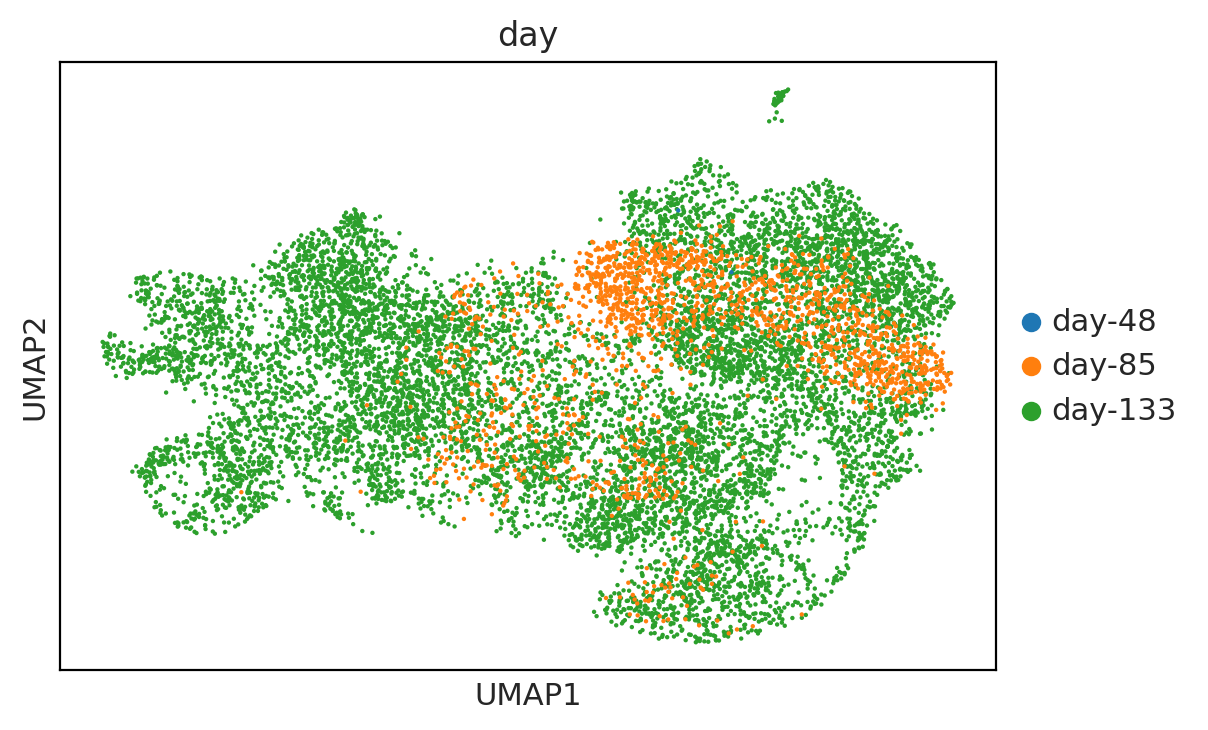

In [4]:
#visualize data
sc.pl.umap(adata, color='day')


In [5]:
#  script to load the data in
def load_adatas(adatas_dict,data_merge, data_key_use,QC_normalise,backed=None):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
            adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            print('Loading anndata {} from local source'.format(dataset))
            if backed == 'r':
                print('Loading data in backed mode! To move into memory run .to_memory()')
            adatas[dataset] = sc.read(adatas_dict[dataset],backed)
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
#             adatas[dataset].obs.index = adatas[dataset].obs.index + dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
            print('All datasets successfully read into a dictionary')
        print('Attempting to collapse dictionary into single joint concatenation')
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner',index_unique=None) # consider only genes that are intersecting
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            print('Loading anndata {} from local source'.format(data_key_use))
            if backed == 'r':
                print('Loading data in backed mode! To move into memory run .to_memory()')
            adata = sc.read(adatas_dict[data_key_use],backed)
    if QC_normalise == True:
        print('option to apply standardisation to data detected, performing basic QC filtering')
        print('Warning we have not implemented a norm check here, so we assume your inut here is raw!')
        adata.raw = adata[:]
        print('Anndata shape is {}'.format(adata.shape))
        #sc.pp.filter_cells(adata, min_genes=200) # No cell filters heren as we want the same [0] dimension as previous analyses
        #sc.pp.filter_genes(adata, min_cells=10) # 
        print('QC filtered Anndata shape is {}'.format(adata.shape))
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
    return adata


Loading anndata fski_qc_norm_scvi from local source
Loading data in backed mode! To move into memory run .to_memory()
Loading anndata fski_velocyto from local source
Loading data in backed mode! To move into memory run .to_memory()


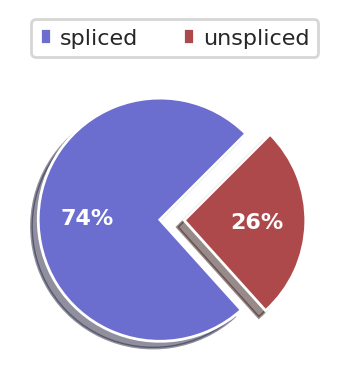

In [6]:
data_key_use = 'fski_qc_norm_scvi'
velo_data = 'fski_velocyto'
var_key = 'org_annot0'
subset_keys = [
    #'Suprabasal IFE', 'Immature basal', 'Immature suprabasal',
 'organoid_Placode/matrix',
 'organoid_Basal',
 'organoid_Outer root sheath',
 'organoid_Basal POSTN+',
 'organoid_Inner root sheath',
 'organoid_Cuticle/cortex',
 'organoid_Companion layer'] #'keratinocytes'
adata_r = load_adatas(data,data_merge = False, data_key_use = data_key_use, QC_normalise = False,backed='r')
adata = adata
adata_vr = load_adatas(data,data_merge = False, data_key_use = velo_data, QC_normalise = False,backed='r')
adata_v = adata_vr[adata_vr.obs.index.isin(adata.obs.index)].to_memory()
scv.pl.proportions(adata_v)
adata_v
var_name = var_key


In [ ]:
data_key_use = 'fski_qc_norm_scvi'
velo_data = 'fski_velocyto'
var_key = 'org_annot0'
subset_keys = [
 'organoid_Placode/matrix',
 'organoid_Basal',
 'organoid_Outer root sheath',
 'organoid_Basal POSTN+',
 'organoid_Inner root sheath',
 'organoid_Cuticle/cortex',
 'organoid_Companion layer'] #'keratinocytes'

integrate = False
lin_vae = False
batches = ['strain']
labels_key = var_key
var_name =var_key
lin_vae=False



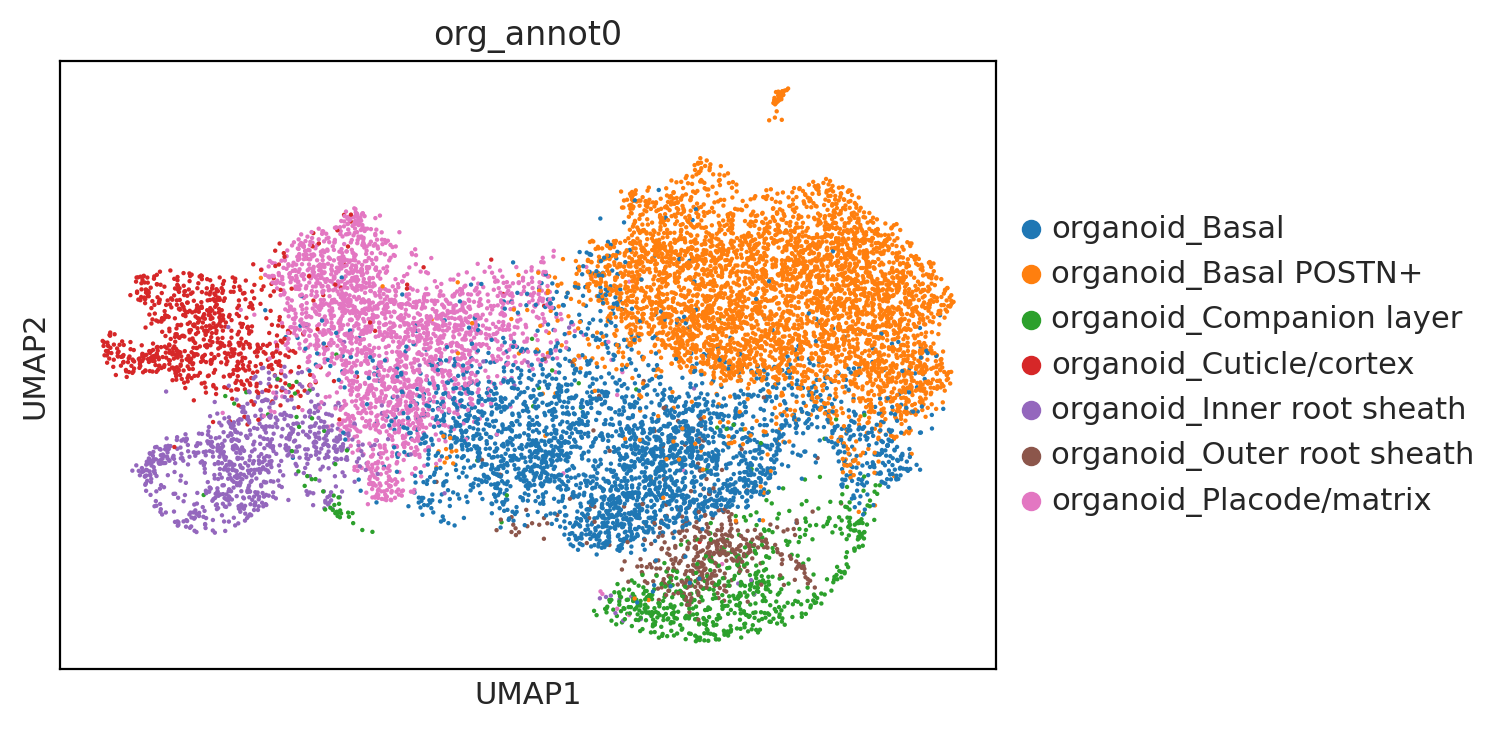

AAACCCACACCTTCCA-1-0        organoid_Placode/matrix
AAACCCAGTCGAACAG-1-0     organoid_Outer root sheath
AAACCCATCATTGTGG-1-0          organoid_Basal POSTN+
AAACGAAAGGCTGAAC-1-0        organoid_Placode/matrix
AAACGAACACGACGCT-1-0        organoid_Placode/matrix
                                    ...            
TTTCCTCTCGATCCCT-1-11                organoid_Basal
TTTGCGCAGGCCCGTT-1-11         organoid_Basal POSTN+
TTTGCGCAGGTAAACT-1-11                organoid_Basal
TTTGCGCCAATCAGAA-1-11                organoid_Basal
TTTGTCAAGGACAGAA-1-11         organoid_Basal POSTN+
Name: org_annot0, Length: 12028, dtype: category
Categories (7, object): ['organoid_Basal', 'organoid_Basal POSTN+', 'organoid_Companion layer', 'organoid_Cuticle/cortex', 'organoid_Inner root sheath', 'organoid_Outer root sheath', 'organoid_Placode/matrix']

In [8]:
# Have a look at  object
sc.pl.umap(adata, color=var_name)

# How are the populations called in this object?
adata.obs[var_name]

In [9]:
# Look at cell number to see how long it will take
adata_v

AnnData object with n_obs × n_vars = 12028 × 36601
    obs: 'new_id', 'sample_id', 'day', 'strain', 'version', 'week', 'nh3_annot1', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'pass_auto_filter', 'scrublet_score', 'scrublet_score_z', 'cluster_scrublet_score', 'bh_pval', 'doublet', 'seurat_clusters', 'org_annot0', 'donor'
    var: 'gene_ids', 'feature_types'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [10]:
# Integrate  object with splicing information
def scvi_integrate_time(adata,lin_vae,batches,labels_key ):
    if lin_vae == True:
        arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        n_hidden=128)

        scvi.model.LinearSCVI.setup_anndata(
        adata,
        labels_key = 'annot',
        layer=None,
        batch_key='lr_batch')

        vae = scvi.model.LinearSCVI(adata, n_latent=20, **arches_params)
        #vae = scvi.model.SCVI(adata, n_latent=30,n_hidden=256, **arches_params)
        vae.train(early_stopping=True,
            train_size=0.2,
            early_stopping_patience=45,
            max_epochs=250, 
            batch_size=1024, 
            limit_train_batches=10#,use_gpu=True
           )
        X_scvi = vae.get_latent_representation()
        X_loading = vae.get_loadings()
        adata.obsm['X_scvi'] = X_scvi
        adata.varm['X_scvi'] = X_loading
    else:
        scvi.model.SCVI.setup_anndata(
        adata,
        layer=None,
        categorical_covariate_keys = batches,
        )
        arches_params = dict(
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        n_hidden=256
        )
        vae = scvi.model.SCVI(adata, n_latent=20,**arches_params)
        vae.train(early_stopping=True,
                train_size=0.5,
                early_stopping_patience=45,
                max_epochs=250, 
                batch_size=1024, 
                limit_train_batches=10#,use_gpu=True
               )
        X_scvi = vae.get_latent_representation()
        adata.obsm['X_scvi'] = X_scvi
        return adata


In [14]:
adata_v

AnnData object with n_obs × n_vars = 12028 × 36601
    obs: 'new_id', 'sample_id', 'day', 'strain', 'version', 'week', 'nh3_annot1', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'pass_auto_filter', 'scrublet_score', 'scrublet_score_z', 'cluster_scrublet_score', 'bh_pval', 'doublet', 'seurat_clusters', 'org_annot0', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_scvi'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [13]:
adata_v = scvi_integrate_time(adata_v,lin_vae,batches,labels_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jovyan/my-conda-envs/clone_20230628_cellrank/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 250/250: 100%|██████████| 250/250 [2:20:15<00:00, 33.28s/it, loss=7.41e+03, v_num=1]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [2:20:15<00:00, 33.66s/it, loss=7.41e+03, v_num=1]


In [44]:
colors_organoid_keratinocytes=['#D72229',  '#8F66A9', '#BABC26', '#8C5A4F', '#7E7E7F','#D179B0', '#CEB08D' ]
colors = colors_organoid_keratinocytes

In [45]:
outlier_detection_removal = True
adata.uns[var_name+'_colors'] = colors

In [15]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_kera_organoid_a1.h5ad"
adata_v.write(filename, compression="lzf")

# Start with velocity analysis

In [4]:
# adata_v = adata_v[:,adata.var.index]
scv.pp.filter_genes(adata_v, min_shared_counts=20)
scv.pp.normalize_per_cell(adata_v)
scv.pp.filter_genes_dispersion(adata_v, n_top_genes=10000)
scv.pp.log1p(adata_v)

NameError: name 'adata_v' is not defined

In [5]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_kera_organoid_c1.h5ad"
adata=sc.read(filename)

In [ ]:
# Copy object and scvi object together
# move graph
partitions = {
'obsm': adata.obsm,
'obs':adata.obs,
'obsp':adata.obsp,
'uns':adata.uns,
}
for partition_key in partitions:
    # this automtically loads the slice into memory, else use the .to_memory() function
    setattr(adata_v,partition_key,partitions[partition_key]) 
adata = adata_v.copy()

In [6]:
kernel = 'scv'#CTK #None defaults to just scVELO
outlier_lambda = -1 # (-) negative values lower the threshold by x*std around the mean of the cluster centeroid
outlier_embedding = 'scvi'
use_smoothing_kernel = True
smoothing_kernel = 'CTK' #or connectivity
basis = 'umap'
ck_weight = 0.3
i_ck_weight = 0.7

In [7]:
print('Computing First and second order splicing dynamics')
scv.pp.moments(adata, use_rep = 'X_scVI', n_pcs=10, n_neighbors=30)# Compute first and second order moments for each cell using the SCVI neighbor graph


Computing First and second order splicing dynamics
computing moments based on connectivities
    finished (0:00:12) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.velocity(adata)

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=var_name)

computing velocities
    finished (0:00:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/60 cores)


  0%|          | 0/12028 [00:00<?, ?cells/s]

In [11]:
print('Computing scv transition matrix representation and embeddings')
from cellrank.kernels import VelocityKernel
scv.tl.recover_dynamics(adata, n_jobs=1) #, n_jobs=-1
scv.tl.velocity(adata)


Computing scv transition matrix representation and embeddings
recovering dynamics (using 1/60 cores)


  0%|          | 0/1531 [00:00<?, ?gene/s]

    finished (0:28:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:13) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [23]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_kera_organoid_b1.h5ad"
adata.write(filename, compression="lzf")

In [12]:
from cellrank.kernels import PseudotimeKernel
pk = PseudotimeKernel(adata, time_key='palantir_pseudotime')
pk.compute_transition_matrix(threshold_scheme="hard", nu=0.5)


vk = VelocityKernel(adata)
vk.compute_transition_matrix()


Computing transition matrix based on pseudotime


  0%|          | 0/12028 [00:00<?, ?cell/s]

    Finish (0:00:05)
Computing transition matrix using `'deterministic'` model


  0%|          | 0/12028 [00:00<?, ?cell/s]

Using `softmax_scale=26.1167`


  0%|          | 0/12028 [00:00<?, ?cell/s]

    Finish (0:01:15)


VelocityKernel[n=12028, model='deterministic', similarity='correlation', softmax_scale=26.117]

In [25]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_fibro_organoid_b1.h5ad"
adata.write(filename, compression="lzf")

Using precomputed projection `adata.obsm['T_fwd_umap']`


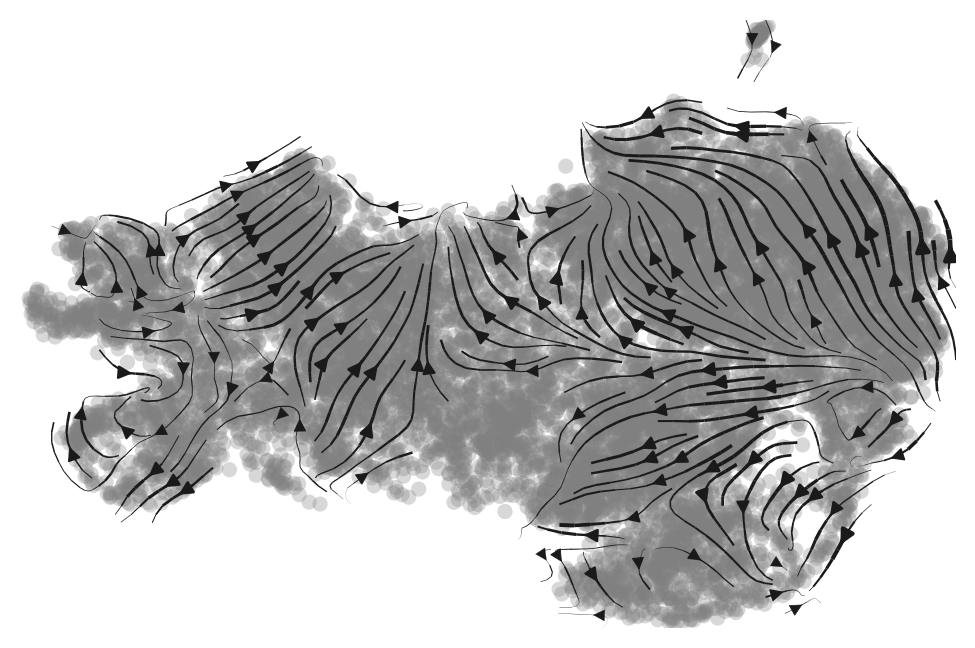

In [13]:
vk.plot_projection(basis="umap", key_added='T_fwd')


Using precomputed projection `adata.obsm['T_fwd_4_umap']`


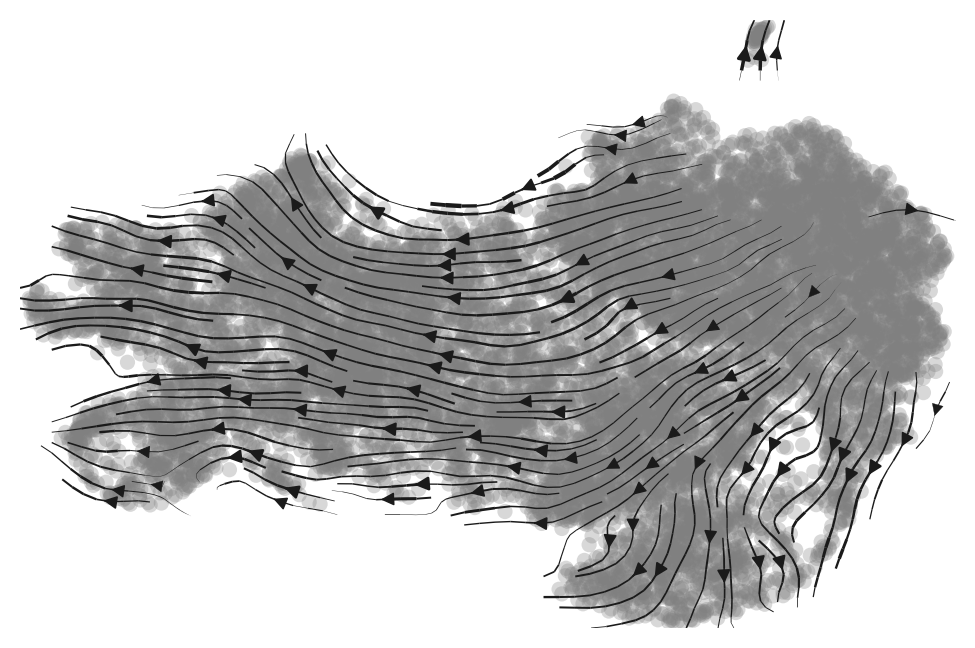

In [14]:
pk.plot_projection(basis="umap", key_added='T_fwd_4')


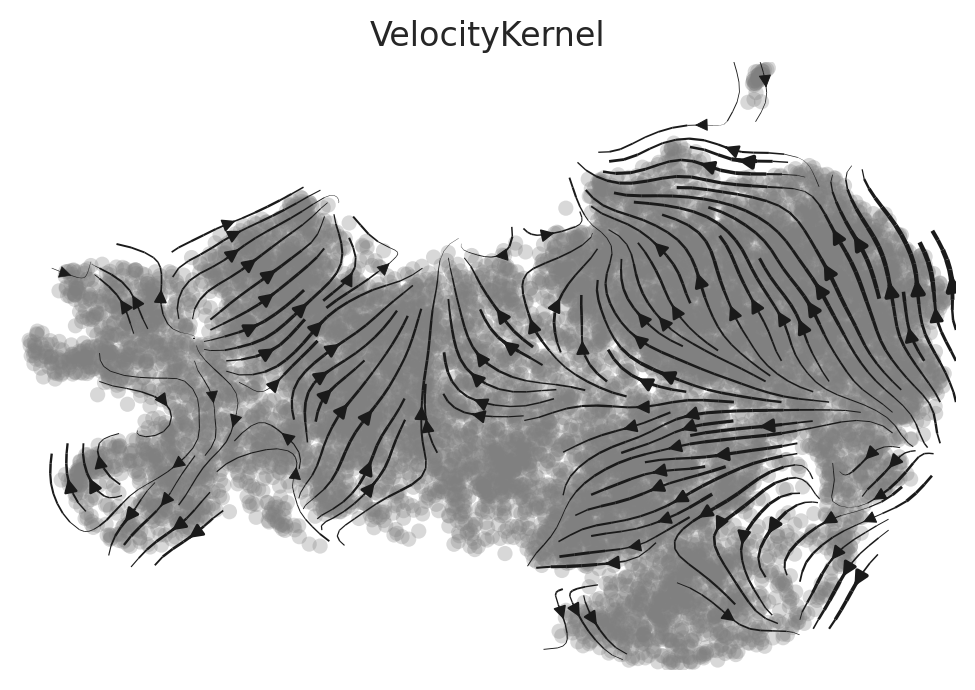

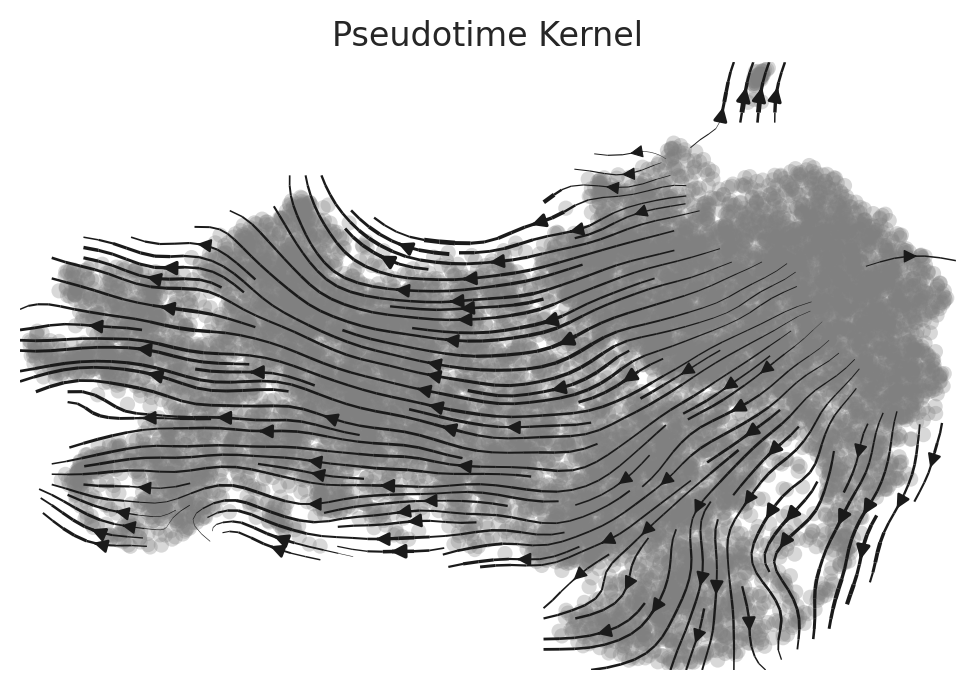

In [47]:
#Plot umaps
scv.pl.velocity_embedding_stream(adata, basis="umap",vkey="T_fwd", legend_fontsize=12, title="VelocityKernel", smooth=0.8, min_mass=3)
scv.pl.velocity_embedding_stream(adata, basis="umap",vkey="T_fwd_4", legend_fontsize=12, title="Pseudotime Kernel", smooth=0.8, min_mass=3)

In [16]:
kernel = 'scv'#CTK #None defaults to just scVELO
outlier_lambda = -1 # (-) negative values lower the threshold by x*std around the mean of the cluster centeroid
outlier_embedding = 'scvi'
use_smoothing_kernel = True
smoothing_kernel = 'CTK' #or connectivity
basis = 'umap'
first_weight = 0.3
second_weight = 0.7
third_weight = 0.5

In [17]:
combined_kernel5 = third_weight * vk + third_weight * pk


In [21]:

w_ck = vk.copy()
w_ck.transition_matrix = combined_kernel5.transition_matrix
w_ck.write_to_adata(key="VelocityPalantir_matrix")


Using precomputed projection `adata.obsm['T_fwd_wck5_umap']`


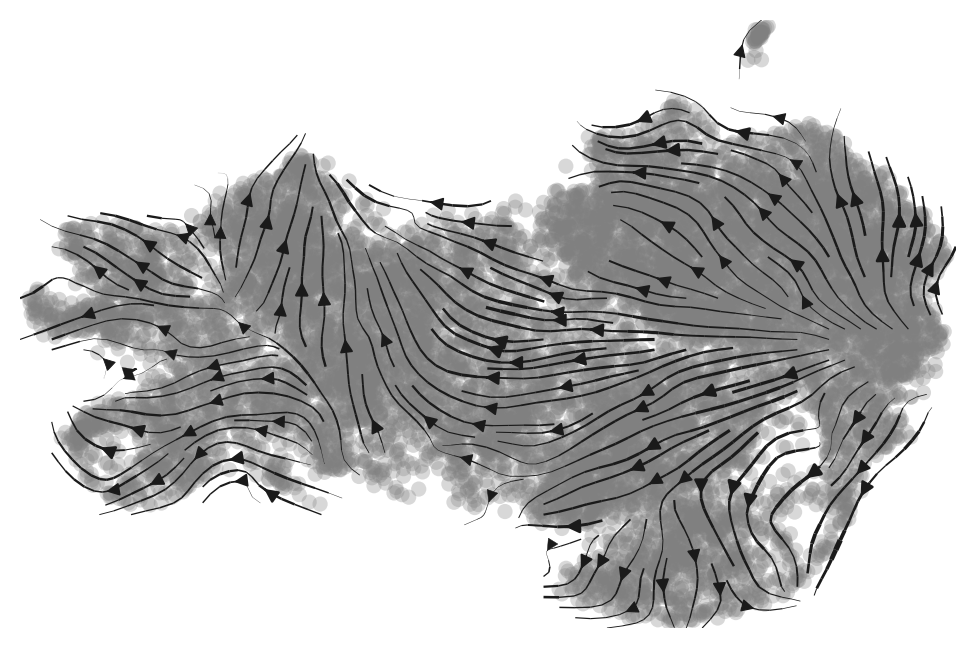

In [62]:
w_ck.plot_projection(basis="umap", key_added='T_fwd_wck5')

In [22]:
colors_organoid_keratinocytes=['#D72229',  '#8F66A9', '#BABC26', '#8C5A4F', '#7E7E7F','#D179B0', '#CEB08D' ]
colors = colors_organoid_keratinocytes
var_name = 'org_annot0'
adata.uns[var_name+'_colors'] = colors


In [46]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/Dinithi_scvelo_kera_organoid_final_pseudotime.h5ad"
adata = sc.read (filename)

# Palantir and velocity kernel

GPCCA[kernel=(0.5 * VelocityKernel[n=12028] + 0.5 * PseudotimeKernel[n=12028]), initial_states=None, terminal_states=None]
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10, 14, 18, 20, 23, 25]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:14)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)
Calculating minChi criterion in interval `[4, 12]`
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:05)


GPCCA[kernel=(0.5 * VelocityKernel[n=12028] + 0.5 * PseudotimeKernel[n=12028]), initial_states=None, terminal_states=None]

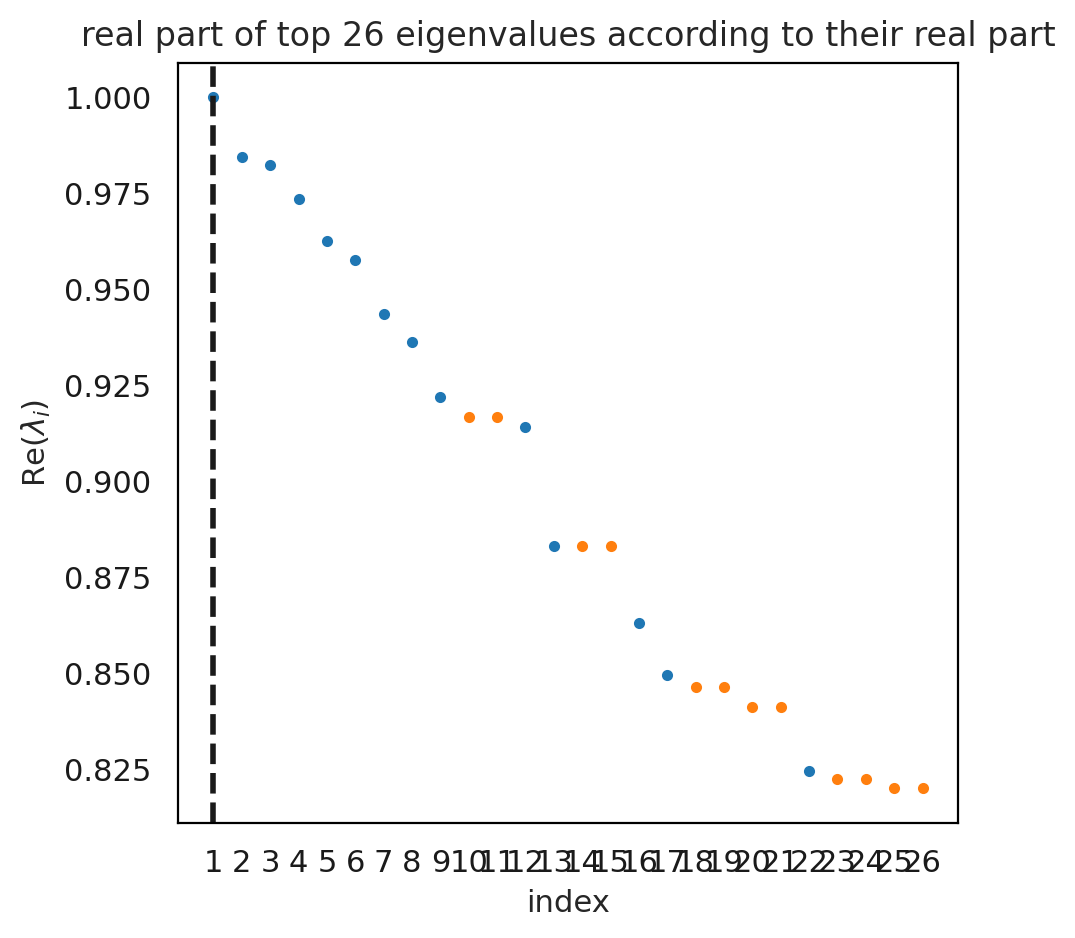

In [48]:
e = cr.estimators.GPCCA(combined_kernel5)
print(e)
e.compute_schur(n_components=25)
e.plot_spectrum(real_only=True)

e.fit(cluster_key=var_name, n_states=[4, 12])


Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)


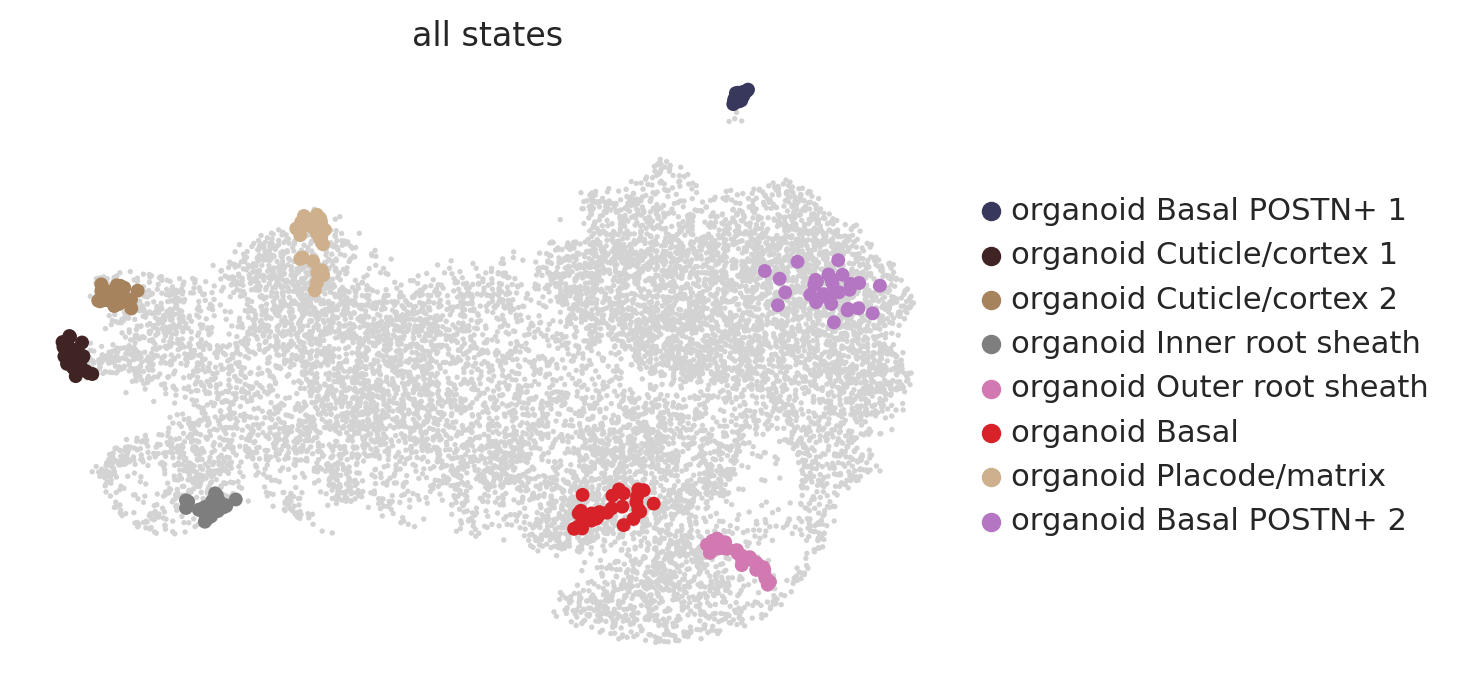

In [49]:
# Here vary a bit to best present data
e.compute_macrostates(n_states=8, cluster_key=var_name)
e.plot_macrostates(which="all", legend_loc="right", s=100)


Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


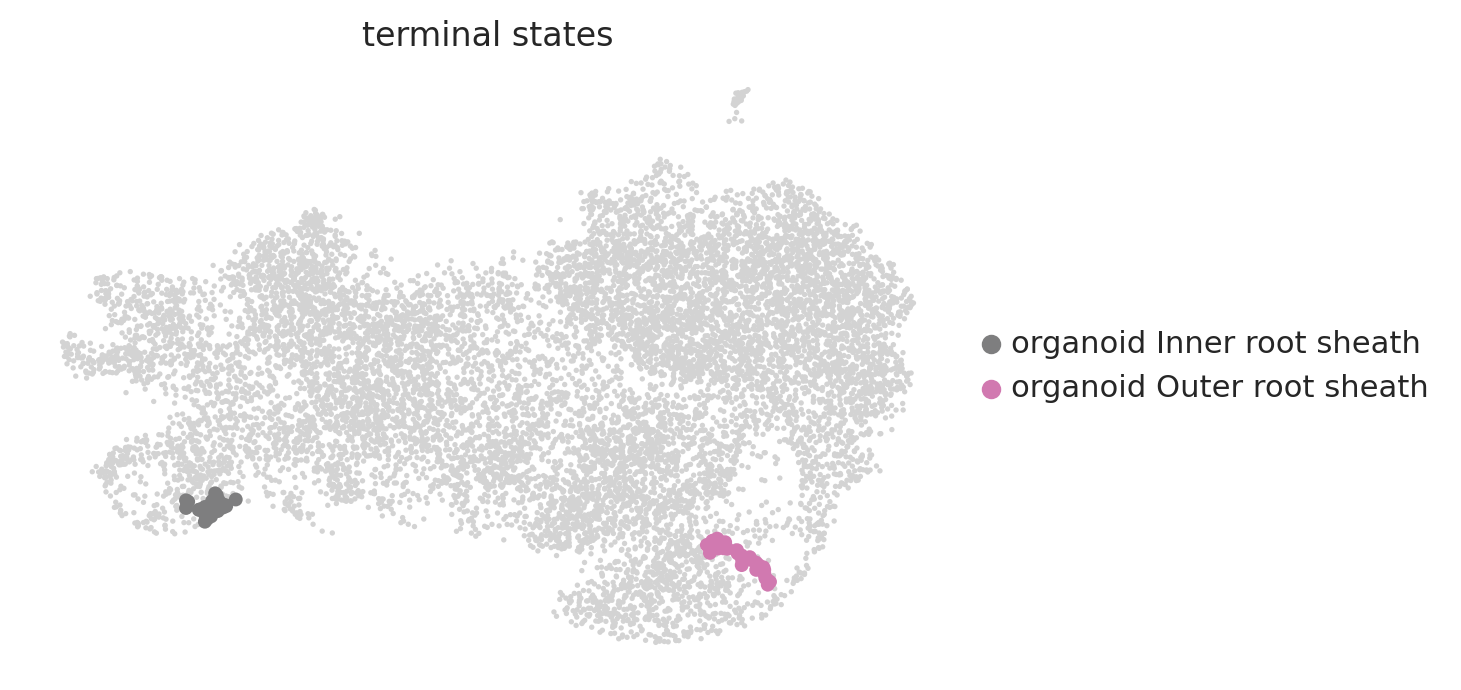

In [50]:

e.set_terminal_states(states=[ 'organoid_Inner root sheath', 'organoid_Outer root sheath'], allow_overlap=True)
e.plot_macrostates(which="terminal", legend_loc="right", s=100)


Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


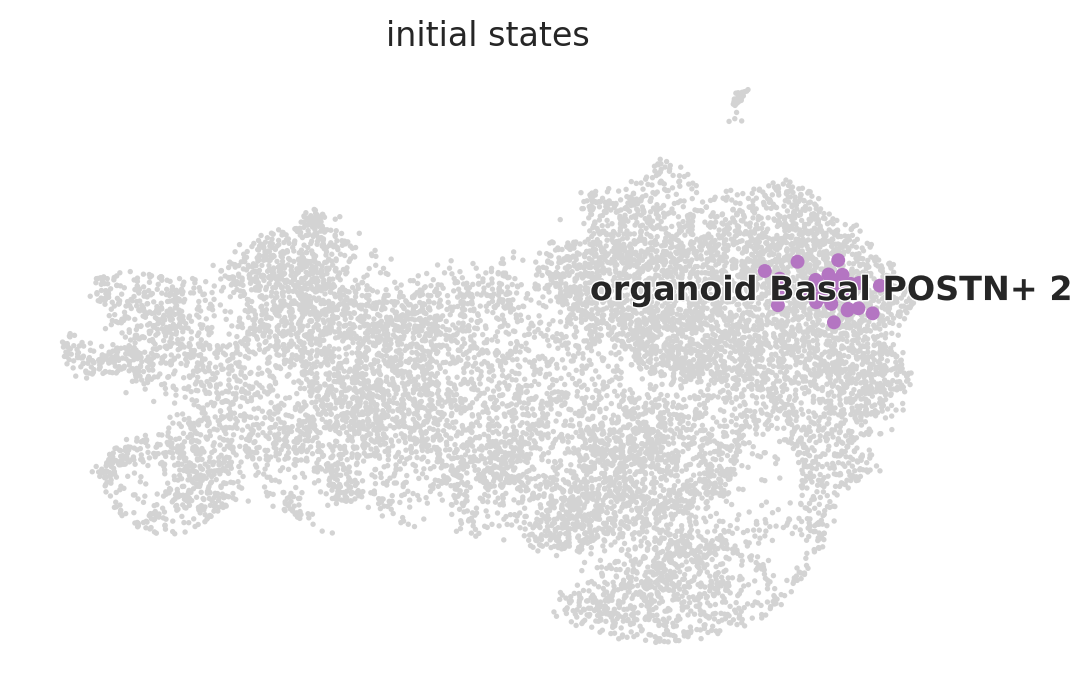

In [51]:
e.set_initial_states(states=["organoid_Basal POSTN+_2"], allow_overlap=True)
e.plot_macrostates(which="initial", s=100)


In [52]:
adata.obsm['term_states_fwd_memberships']

array([[0.08773928, 0.09551387],
       [0.08569785, 0.42296888],
       [0.07627122, 0.11104489],
       ...,
       [0.08139189, 0.11917613],
       [0.08696143, 0.0933982 ],
       [0.07553288, 0.1108755 ]])

In [53]:
e.compute_fate_probabilities()
e.compute_lineage_drivers()


Computing fate probabilities


  0%|          | 0/2 [00:00<?, ?/s]

[0]PETSC ERROR: 

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:02)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


organoid_Inner root sheath_corr  organoid_Inner root sheath_pval  \
KRT25                           0.261634                    1.202425e-189   
KRT71                           0.251253                    2.094489e-174   
KRT28                           0.241496                    9.673109e-161   
ID3                             0.218879                    1.853384e-131   
CTSC                            0.217366                    1.291205e-129   
...                                  ...                              ...   
CARD18                         -0.478812                     0.000000e+00   
ACSM6                          -0.483683                     0.000000e+00   
KRT79                          -0.497294                     0.000000e+00   
ACSBG1                         -0.522906                     0.000000e+00   
HSD17B2                        -0.547429                     0.000000e+00   

         organoid_Inner root sheath_qval  organoid_Inner root sheath_ci_low  \
KRT25                      4.294375e-187                           0.244908   
KRT71                      6.160263e-172                           0.234434   
KRT28                      2.480284e-158                           0.224593   
ID3                        3.432193e-129                           0.201797   
CTSC                       2.265273e-127                           0.200272   
...                                  ...                                ...   
CARD18                      0.000000e+00                          -0.492469   
ACSM6                       0.000000e+00                          -0.497256   
KRT79                       0.000000e+00                          -0.510627   
ACSBG1                      0.000000e+00                          -0.535771   
HSD17B2                     0.000000e+00                          -0.559824   

         organoid_Inner root sheath_ci_high  organoid_Outer root sheath_corr  \
KRT25                              0.278205                        -0.261639   
KRT71                              0.267921                        -0.251259   
KRT28                              0.258252                        -0.241498   
ID3                                0.235828                        -0.218881   
CTSC                               0.234327                        -0.217370   
...                                     ...                              ...   
CARD18                            -0.464919                         0.478809   
ACSM6                             -0.469873                         0.483683   
KRT79                             -0.483722                         0.497292   
ACSBG1                            -0.509799                         0.522905   
HSD17B2                           -0.534790                         0.547427   

         organoid_Outer root sheath_pval  organoid_Outer root sheath_qval  \
KRT25                      1.184654e-189                    4.230906e-187   
KRT71                      2.054185e-174                    6.041719e-172   
KRT28                      9.602760e-161                    2.462246e-158   
ID3                        1.847096e-131                    3.420549e-129   
CTSC                       1.275651e-129                    2.237985e-127   
...                                  ...                              ...   
CARD18                      0.000000e+00                     0.000000e+00   
ACSM6                       0.000000e+00                     0.000000e+00   
KRT79                       0.000000e+00                     0.000000e+00   
ACSBG1                      0.000000e+00                     0.000000e+00   
HSD17B2                     0.000000e+00                     0.000000e+00   

         organoid_Outer root sheath_ci_low  organoid_Outer root sheath_ci_high  
KRT25                            -0.278209                           -0.244912  
KRT71                            -0.267927                           -0.234440  
KRT28 

In [54]:
scv.tl.velocity_graph(adata, vkey='VelocityPalantir_matrix')
scv.tl.velocity_pseudotime(adata, vkey='VelocityPalantir_matrix')
scv.tl.latent_time(adata, vkey='VelocityPalantir_matrix', root_key='init_states_fwd_probs', end_key='term_states_fwd_probs')

computing velocities
    finished (0:00:14) --> added 
    'VelocityPalantir_matrix', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/60 cores)


  0%|          | 0/12028 [00:00<?, ?cells/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple MacOS to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
[unset]: write_line error; fd=-1 buf=:cmd=abort exitcode=59
:
system msg for write_line failure : Bad file descriptor


    finished (0:00:50) --> added 
    'VelocityPalantir_matrix_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using init_states_fwd_probs, term_states_fwd_probs as prior
    finished (0:00:10) --> added 
    'latent_time', shared time (adata.obs)


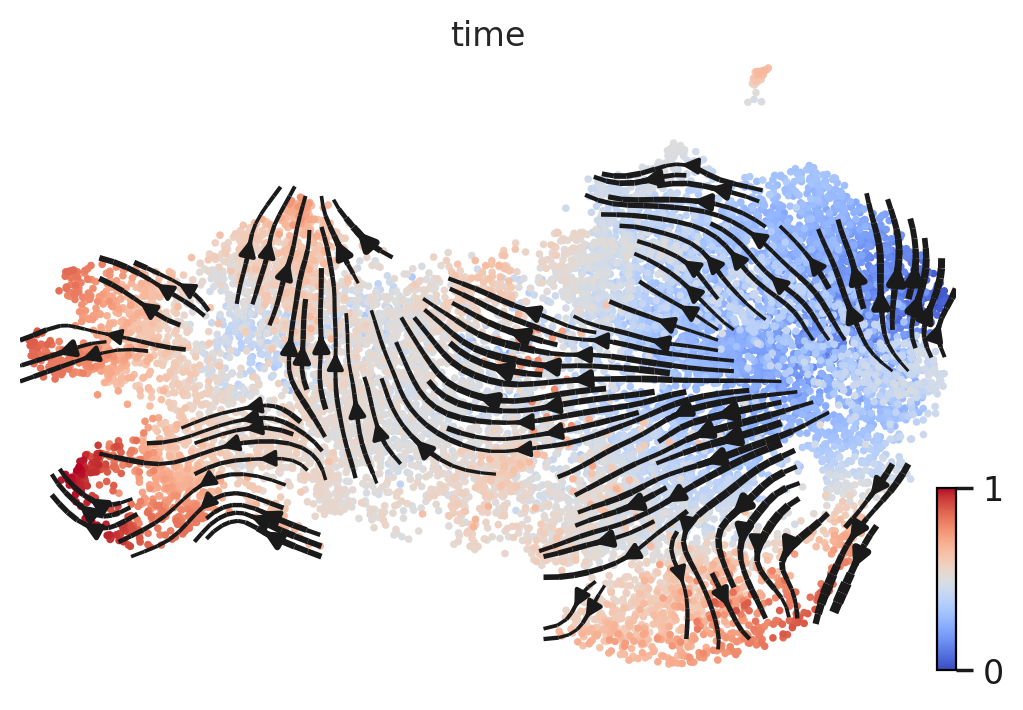

In [61]:

scv.pl.velocity_embedding_stream(adata, color='latent_time',  
                                 color_map= 'coolwarm', basis="umap",vkey="T_fwd_wck5", legend_fontsize=12, 
                                 title="time", smooth=0.8, min_mass=4, size=30,alpha=1,arrowsize=1.2, 
                                 linewidth=2)

running PAGA using priors: ['latent_time']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


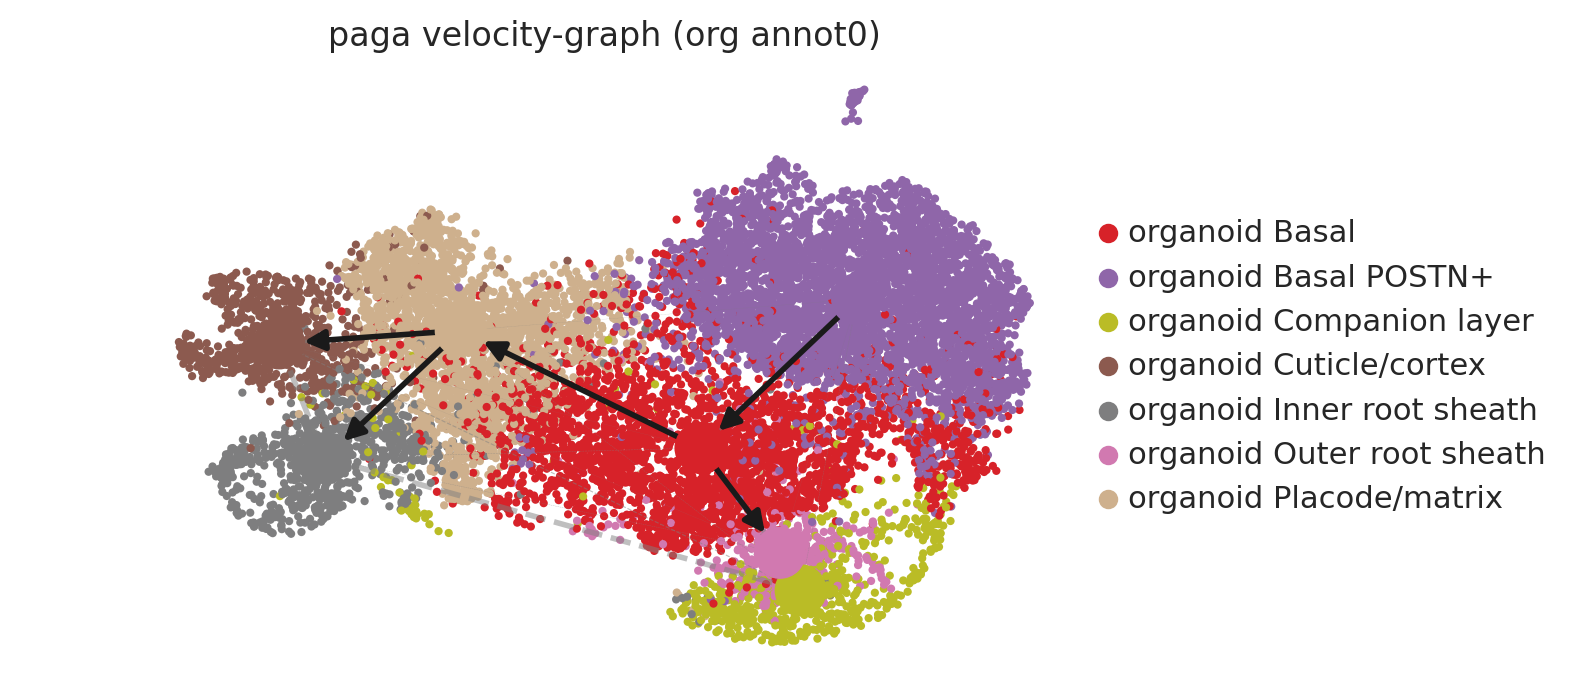

In [56]:
scv.tl.paga(adata, groups=var_name, vkey='velocity', use_time_prior='latent_time')
scv.pl.paga(adata, basis='umap', color=var_name, vkey='velocity',
            node_size_scale=2,node_size_power=0, min_edge_width=2,fontsize=14,
            legend_loc='right margin', use_raw=False, size=35, alpha=1, frameon=False)


In [56]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_kera_organoid_final_palantir.h5ad"
adata.write(filename, compression="lzf")

In [63]:
inner_df = e.compute_lineage_drivers(lineages=["organoid_Inner root sheath"])
outer_df = e.compute_lineage_drivers(lineages=["organoid_Outer root sheath"])


Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


# Get lineage drivers for each individual population

GPCCA[kernel=(0.5 * VelocityKernel[n=12028] + 0.5 * PseudotimeKernel[n=12028]), initial_states=['organoid_Basal POSTN+_2'], terminal_states=['organoid_Inner root sheath', 'organoid_Outer root sheath']]
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10, 14, 18, 20, 23, 25]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:15)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:04)
Calculating minChi criterion in interval `[4, 12]`
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecompo

GPCCA[kernel=(0.5 * VelocityKernel[n=12028] + 0.5 * PseudotimeKernel[n=12028]), initial_states=None, terminal_states=None]

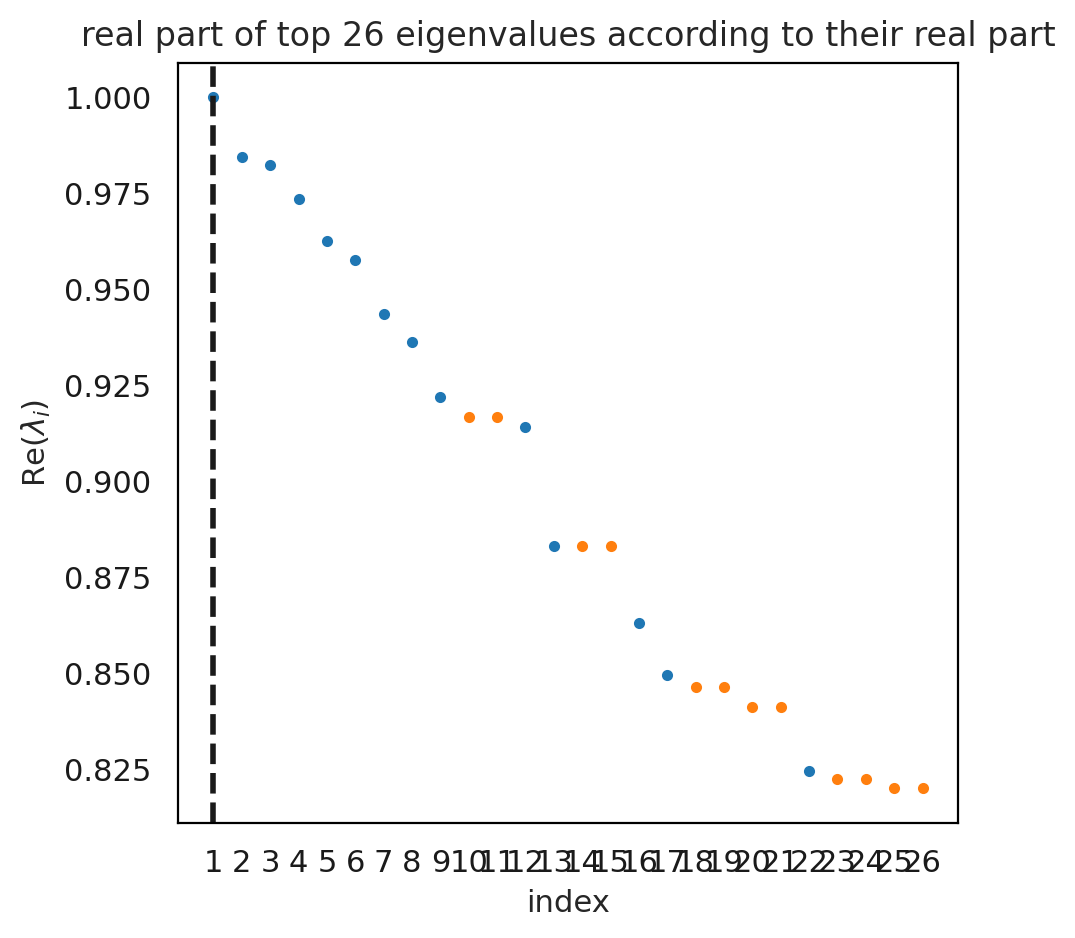

In [64]:
g = cr.estimators.GPCCA(combined_kernel5)
print(e)
g.compute_schur(n_components=25)
g.plot_spectrum(real_only=True)

g.fit(cluster_key=var_name, n_states=[4, 12])

Computing `13` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:02:20)


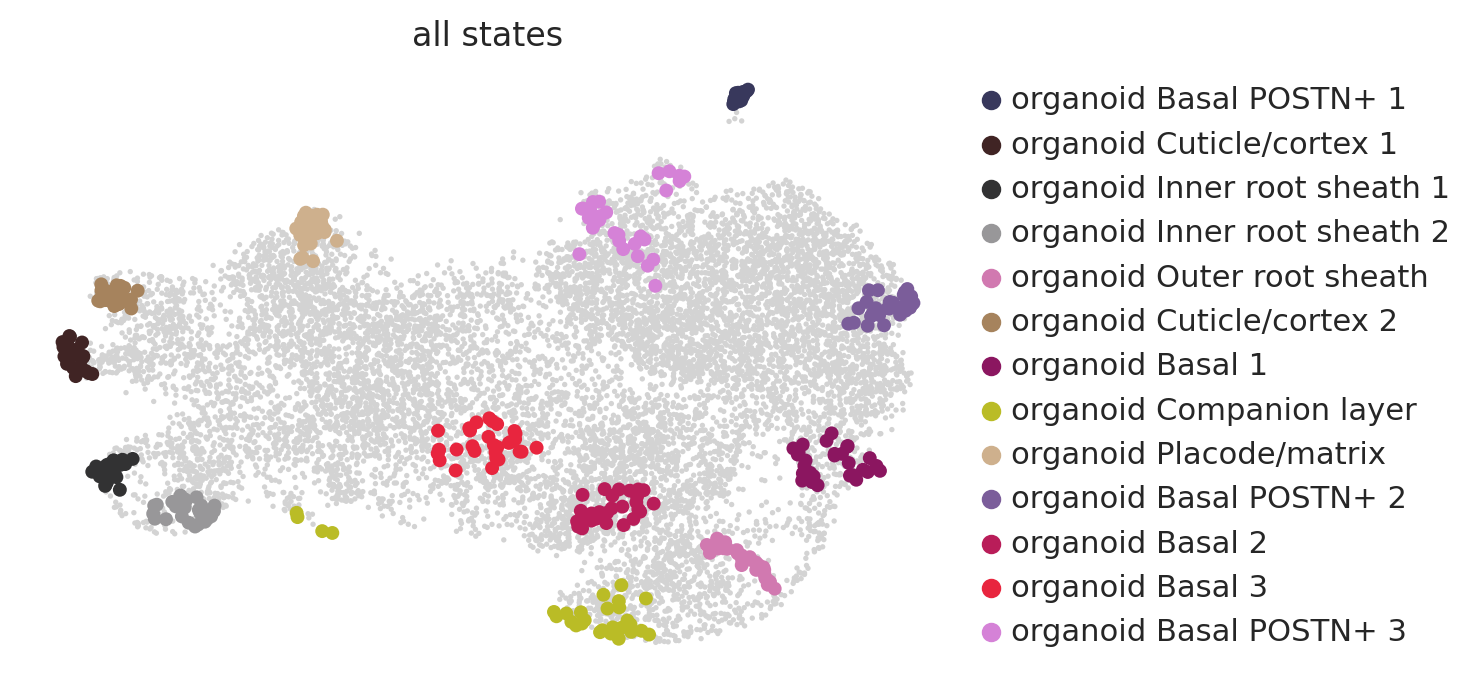

In [65]:
# Here vary a bit to best present data
g.compute_macrostates(n_states=13, cluster_key=var_name)
g.plot_macrostates(which="all", legend_loc="right", s=100)


Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


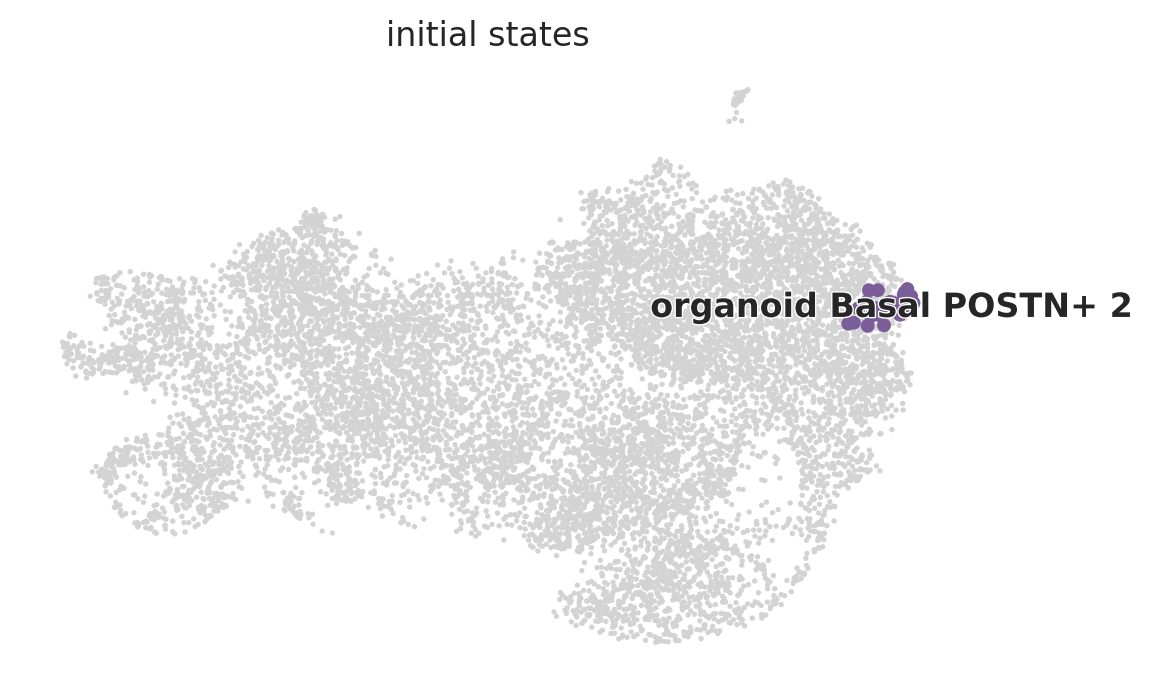

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


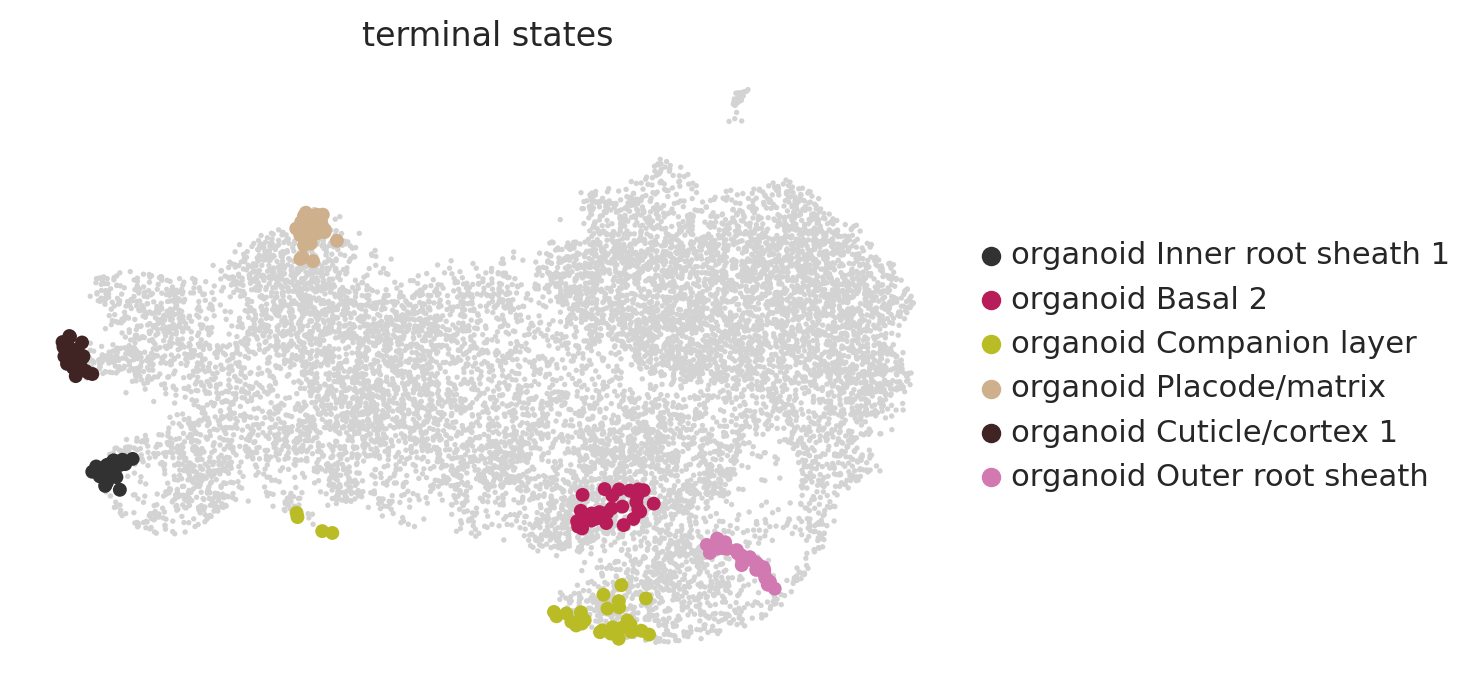

In [67]:
g.set_initial_states(states=["organoid_Basal POSTN+_2"], allow_overlap=True)
g.plot_macrostates(which="initial", s=100)
g.set_terminal_states(states=[ 'organoid_Inner root sheath_1', 'organoid_Basal_2','organoid_Companion layer', 'organoid_Placode/matrix', 'organoid_Cuticle/cortex_1' ,'organoid_Outer root sheath'], allow_overlap=True)
g.plot_macrostates(which="terminal", legend_loc="right", s=100)


In [68]:
g.compute_fate_probabilities()
g.compute_lineage_drivers()

Computing fate probabilities


  0%|          | 0/6 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------


Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:03)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:01)


organoid_Inner root sheath_1_corr  \
KRT73                              0.703096   
KRT71                              0.607973   
KRT74                              0.578865   
CRNN                               0.575989   
CTSC                               0.531299   
...                                     ...   
MIR205HG                          -0.253856   
KRT5                              -0.261885   
RPLP1                             -0.268522   
GPNMB                             -0.269107   
LY6G6D                            -0.280195   

          organoid_Inner root sheath_1_pval  \
KRT73                          0.000000e+00   
KRT71                          0.000000e+00   
KRT74                          0.000000e+00   
CRNN                           0.000000e+00   
CTSC                           0.000000e+00   
...                                     ...   
MIR205HG                      3.693374e-178   
KRT5                          5.051613e-190   
RPLP1                         3.647688e-200   
GPNMB                         4.503213e-201   
LY6G6D                        9.521799e-219   

          organoid_Inner root sheath_1_qval  \
KRT73                          0.000000e+00   
KRT71                          0.000000e+00   
KRT74                          0.000000e+00   
CRNN                           0.000000e+00   
CTSC                           0.000000e+00   
...                                     ...   
MIR205HG                      3.929121e-176   
KRT5                          5.873968e-188   
RPLP1                         4.617326e-198   
GPNMB                         5.773349e-199   
LY6G6D                        1.304356e-216   

          organoid_Inner root sheath_1_ci_low  \
KRT73                                0.693944   
KRT71                                0.596584   
KRT74                                0.566858   
CRNN                                 0.563922   
CTSC                                 0.518349   
...                                       ...   
MIR205HG                            -0.270500   
KRT5                                -0.278453   
RPLP1                               -0.285025   
GPNMB                               -0.285605   
LY6G6D                              -0.296582   

          organoid_Inner root sheath_1_ci_high  organoid_Basal_2_corr  \
KRT73                                 0.712021              -0.132075   
KRT71                                 0.619118              -0.166721   
KRT74                                 0.590626              -0.135453   
CRNN                                  0.587809              -0.146544   
CTSC                                  0.544005              -0.167603   
...                                        ...                    ...   
MIR205HG                             -0.237060               0.224986   
KRT5                                 -0.245161               0.224702   
RPLP1                                -0.251859               0.109742   
GPNMB                                -0.252449               0.007922   
LY6G6D                               -0.263644              -0.174918   

          organoid_Basal_2_pval  organoid_Basal_2_qval  \
KRT73              4.468433e-48           1.642806e-46   
KRT71              4.782355e-76           3.795520e-74   
KRT74              1.669172e-50           6.840869e-49   
CRNN               6.295009e-59           3.211739e-57   
CTSC               7.553291e-77           6.091364e-75   
...                         ...                    ...   
MIR205HG          4.847891e-139          1.514966e-136   
KRT5              1.105594e-138          3.251747e-136   
RPLP1              1.301521e-33           2.717164e-32   
GPNMB              3.849897e-01           4.610103e-01   
LY6G6D             1.126806e-83           1.073148e-81   

          organoid_Basal_2_ci_low  organoid_Basal_2_ci_high  ...  \
KRT73                   -0.149594                 -0.114474  ...   
KRT71           

In [71]:
Companionlayer_df = g.compute_lineage_drivers(
    lineages=["organoid_Companion layer"]
)

Placodematrix_df = g.compute_lineage_drivers(
    lineages=["organoid_Placode/matrix"]
)
Cuticlecortex_df = g.compute_lineage_drivers(
    lineages=["organoid_Cuticle/cortex_1"]
)

Basal_df = g.compute_lineage_drivers(
    lineages=["organoid_Basal_2"]
)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
